#### Fuels types by ZIP Codes

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from pywaffle import Waffle
from altair import datum
import altair as alt
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
alt.data_transformers.disable_max_rows()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
src = pd.read_csv('https://data.ca.gov/dataset/15179472-adeb-4df6-920a-20640d02b08c/resource/4254a06d-9937-4083-9441-65597dd267e8/download/vehicle-count-as-of-1-1-2020.csv', low_memory=False)

In [3]:
src.head()

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,1/1/2020,90001,2007,Gasoline,ACURA,Light,15
1,1/1/2020,90002,2007,Gasoline,ACURA,Light,20
2,1/1/2020,90003,2007,Gasoline,ACURA,Light,29
3,1/1/2020,90004,2007,Gasoline,ACURA,Light,19
4,1/1/2020,90006,2007,Gasoline,ACURA,Light,15


In [4]:
df = src.copy()

### Clean up field names

In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [6]:
df.rename(columns={"zip_code": "zip"}, inplace=True)

### How many vehicles are we talking about? 

In [7]:
'{:,.0f}'.format(df.vehicles.sum())

'31,233,841'

In [8]:
df.columns

Index(['date', 'zip', 'model_year', 'fuel', 'make', 'duty', 'vehicles'], dtype='object')

### Remove unknown, out of state and heavy duty models.

In [9]:
vehicles = pd.DataFrame(df[(df['duty'] != 'Heavy') & \
                          (df['model_year'] != '<2007') &\
                          (df['zip'] != 'OOS')])

---

### Aggregate by ZIP Codes

In [10]:
vehicles_grp = vehicles.groupby(['zip', 'fuel']).agg({'vehicles': 'sum'}).reset_index()

In [11]:
vehicles_grp.head()

,zip,fuel,vehicles
0,90000,Gasoline,8
1,90001,Battery Electric,21
2,90001,Diesel and Diesel Hybrid,105
3,90001,Flex-Fuel,790
4,90001,Gasoline,15955


In [42]:
zips_pivot = pd.pivot_table(vehicles_grp, values='vehicles', index=['zip'], columns=['fuel'], aggfunc=np.sum, fill_value=0).reset_index()
zips_pivot.columns = zips_pivot.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Calculate totals and share

In [43]:
zips_pivot['total_vehicles'] = zips_pivot.sum(numeric_only=True, axis=1)

In [47]:
zips_pivot['gasoline_pct'] = round((zips_pivot['gasoline'] / zips_pivot['total_vehicles'])*100,2)

### How many would meet 2035 standard?

In [48]:
zips_pivot['cvrp_total'] = zips_pivot['battery_electric'] + zips_pivot['hydrogen_fuel_cell']

### What's the share of those in each of the ZIP Codes?

In [52]:
zips_pivot['cvrp_pct'] = round((zips_pivot['cvrp_total'] / zips_pivot['total_vehicles'])*100,2)

### Which (large) ZIP Codes have the highest share of battery-electric vehicles? 

In [51]:
zips_pivot[zips_pivot['total_vehicles'] > 1000].sort_values('cvrp_pct', ascending=False).head()

---

## Geography

In [67]:
# Filtered CA from this national file maintained by Esri: 
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_ZIP_Code_Areas_anaylsis/FeatureServer/0/
zips_poly_pop = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri.geojson').fillna('0')
zips_poly = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri-demographics.geojson').fillna('0')

In [68]:
zips_poly_pop.columns = zips_poly_pop.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [69]:
zips_poly.columns = zips_poly.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [74]:
zips_poly_pop['population'] = zips_poly_pop['population'].astype(int)

<AxesSubplot:>

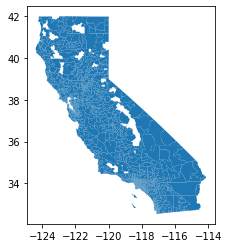

In [76]:
zips_poly_pop[zips_poly_pop['population'] > 0].plot()

In [80]:
zips_poly_pop[zips_poly_pop['population'] > 0].head()

,zip_code,po_name,state,population,sqmi,geometry
8,90001,Los Angeles,CA,60012,3.53,"MULTIPOLYGON (((-118.23099 33.95839, -118.2310..."
9,90002,Los Angeles,CA,53235,3.10,"MULTIPOLYGON (((-118.25729 33.93481, -118.2571..."
10,90003,Los Angeles,CA,71274,3.51,"MULTIPOLYGON (((-118.28009 33.93826, -118.2799..."
11,90004,Los Angeles,CA,64682,3.12,"MULTIPOLYGON (((-118.28434 34.06852, -118.2843..."
12,90005,Los Angeles,CA,46044,1.56,"MULTIPOLYGON (((-118.32298 34.05464, -118.3227..."


In [63]:
zips_pivot_geo = zips_poly_pop.merge(zips_pivot, left_on='zip_code', right_on='zip')

<AxesSubplot:>

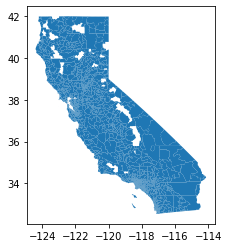

In [64]:
zips_pivot_geo.plot()

In [65]:
zips_pivot_geo.head()

,zip_code,po_name,state,population,sqmi,geometry,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total_vehicles,cvrp_total,gasoline_pct,cvrp_pct
0,90001,Los Angeles,CA,60012,3.53,"MULTIPOLYGON (((-118.23099 33.95839, -118.2310...",90001,21,105,790,15955,453,0,4,0,46,17374,21,91.83,0.12
1,90002,Los Angeles,CA,53235,3.10,"MULTIPOLYGON (((-118.25729 33.93481, -118.2571...",90002,31,52,765,14659,394,0,0,0,50,15951,31,91.90,0.19
2,90003,Los Angeles,CA,71274,3.51,"MULTIPOLYGON (((-118.28009 33.93826, -118.2799...",90003,25,54,912,19336,541,1,6,0,43,20918,26,92.44,0.12
3,90004,Los Angeles,CA,64682,3.12,"MULTIPOLYGON (((-118.28434 34.06852, -118.2843...",90004,345,79,417,19646,1789,14,5,0,302,22597,359,86.94,1.59
4,90005,Los Angeles,CA,46044,1.56,"MULTIPOLYGON (((-118.32298 34.05464, -118.3227...",90005,116,51,215,11019,840,3,2,0,164,12410,119,88.79,0.96


In [81]:
breaks = jenkspy.jenks_breaks(zips_pivot_geo.cvrp_pct, nb_class=7)

In [82]:
breaks

[0.0, 0.59, 1.41, 2.41, 3.87, 5.84, 8.45, 12.76]

In [83]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [84]:
zips_pivot_geo['cvrp_group'] = zips_pivot_geo.cvrp_pct.apply(get_group)

In [87]:
zips_pivot_geo.sort_values('cvrp_group', ascending=False).head()

,zip_code,po_name,state,population,sqmi,geometry,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total_vehicles,cvrp_total,gasoline_pct,cvrp_pct,cvrp_group
372,92093,La Jolla,CA,8224,1.19,"MULTIPOLYGON (((-117.25225 32.86527, -117.2522...",92093,55,3,50,210,92,0,14,0,7,431,55,48.72,12.76,6
972,94028,Portola Valley,CA,6690,14.45,"MULTIPOLYGON (((-122.18826 37.32111, -122.1881...",94028,494,110,105,3378,554,2,1,1,149,4794,496,70.46,10.35,6
925,94027,Atherton,CA,7027,5.25,"MULTIPOLYGON (((-122.22562 37.42404, -122.2246...",94027,598,79,146,3771,390,2,0,0,146,5132,600,73.48,11.69,6
923,94022,Los Altos,CA,20513,17.82,"MULTIPOLYGON (((-122.17233 37.32858, -122.1723...",94022,1531,180,257,9984,1319,7,0,0,419,13697,1538,72.89,11.23,6
973,94024,Los Altos,CA,22947,7.81,"MULTIPOLYGON (((-122.08339 37.32425, -122.0831...",94024,1558,227,240,10843,1475,19,4,0,504,14870,1577,72.92,10.61,6


In [90]:
zips_pivot_geo.to_file('/Users/mhustiles/data/data/GIS/zips_pivot_geo.geojson', driver='GeoJSON')